
##  Regression on Movies data


Your boss has just acquired data about how much audiences and critics like movies as well as numerous other variables about the movies. This dataset is provided below, and it includes information from Rotten Tomatoes and IMDB for a random sample of movies.

She is interested in learning what attributes make a movie popular. She is also interested in learning something new about movies. She wants your team to figure it all out.

In [122]:
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages("tidyverse")
#install.packages("corrplot")

library(ggplot2)
library(dplyr)
library(tidyverse)
library(corrplot)

In [123]:
setwd("D:/Folders/R/Linear Regression")
getwd()

[1] "D:/Folders/R/Linear Regression"

In [124]:
load("movies.Rdata")



###  Part 1: Data




The data set is comprised of 651 randomly sampled movies produced and released before 2016, including information from Rotten Tomatoes and IMDB.

Therefore, studies based on this sample is:

■ generalizable to the movie released before 2016;

■ not causal, since no random assignment is used in sample collecting.



###  Part 2: Research Question




There is one thing which I would like to explore through this dataset:

■ How are the Critics score compared to the Audience Score, and if we could predict the critics score from the audience score



###  Part 3: Exploratory data analysis




In [125]:
head(movies)

title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,dvd_rel_year,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
Filly Brown,Feature Film,Drama,80,R,Indomina Media Inc.,2013,4,19,2013,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
The Dish,Feature Film,Drama,101,PG-13,Warner Bros. Pictures,2001,3,14,2001,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
Waiting for Guffman,Feature Film,Comedy,84,R,Sony Pictures Classics,1996,8,21,2001,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
The Age of Innocence,Feature Film,Drama,139,PG,Columbia Pictures,1993,10,1,2001,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
Malevolence,Feature Film,Horror,90,R,Anchor Bay Entertainment,2004,9,10,2005,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/
Old Partner,Documentary,Documentary,78,Unrated,Shcalo Media Group,2009,1,15,2010,...,no,no,Chung-ryoul Lee,Choi Won-kyun,Lee Sam-soon,Moo,NA,NA,http://www.imdb.com/title/tt1334549/,//www.rottentomatoes.com/m/old-partner/


In [126]:
#removing unwanted columns
movies2 <- movies[,-c(10:12,24:32)]

In [127]:
#combining theater release date
movies2$release_date <- as.Date(with(movies2, paste(thtr_rel_year, thtr_rel_month, thtr_rel_day,sep="-")), "%Y-%m-%d")
movies3 <- movies2[,-c(7:9)]

In [128]:
#creating a column based on Oscar won or not
movies3$oscar_won <- with(movies3, ifelse(best_pic_win == "yes" | best_actor_win == "yes" | best_actress_win == "yes" | best_dir_win == "yes", "yes", "no"))

We'll look at the scatterplot for Audience Rating vs Critics Rating

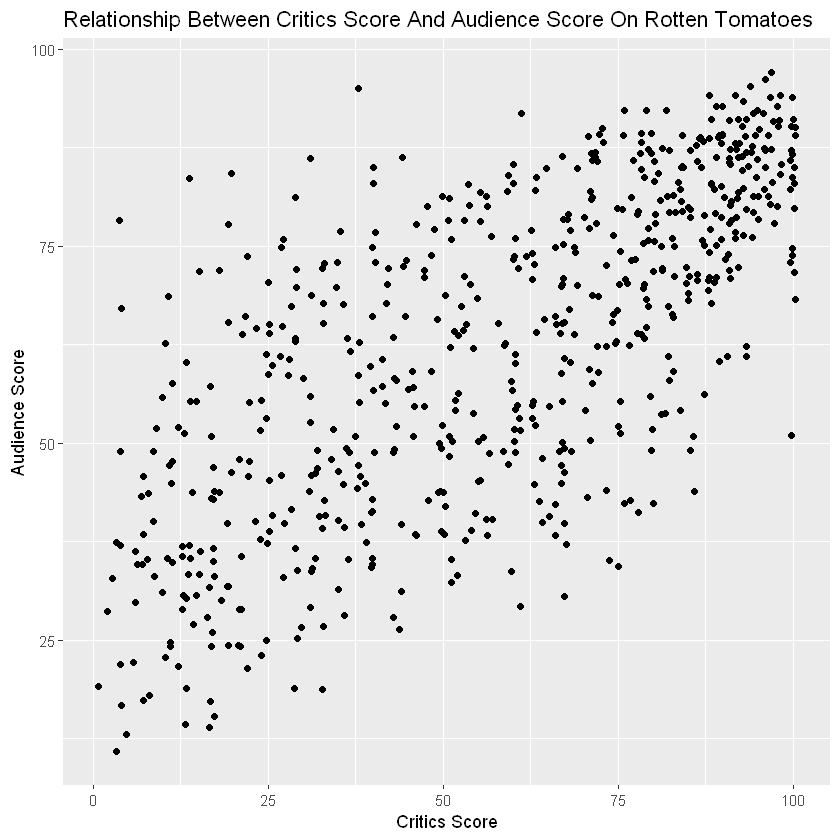

In [129]:
ggplot(data = movies3, aes(x = critics_score, y = audience_score)) +
  geom_jitter() +
  labs(x = "Critics Score", y = "Audience Score") +
  ggtitle("Relationship Between Critics Score And Audience Score On Rotten Tomatoes")

It seems like a positive linear correlation. We can find the Pearson's R to validate. We can also infer from the graph that the Audience and Critics are "less likely" to agree with one another on the low scoring movies than on higher scoring movies

In [130]:
cor(movies3$critics_score,movies3$audience_score)

[1] 0.7042762

Before building the linear regression model, let's search for some other variables that may contribute to it. We would say that the audience score would vary with the genre (genre of the movie)

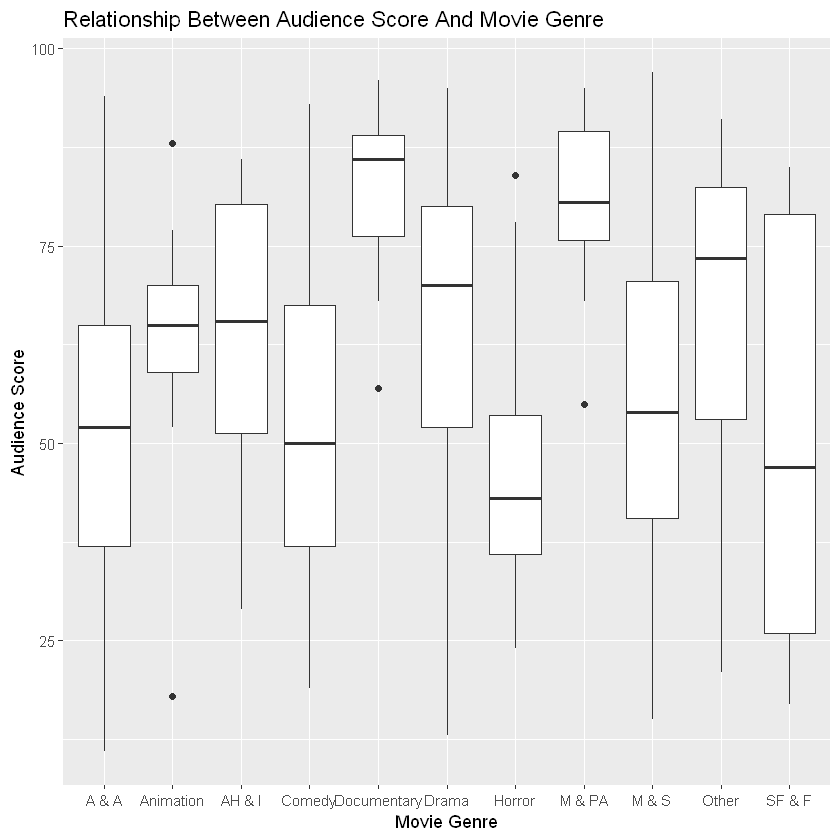

In [131]:
ggplot(data = movies3, aes(x = genre, y = audience_score)) +
  geom_boxplot() +
  labs(x = "Movie Genre", y = "Audience Score") +
  ggtitle("Relationship Between Audience Score And Movie Genre") +
# aliasing for long genre names
  scale_x_discrete(labels = c("Action & Adventure" = "A & A", "Art House & International" = "AH & I", "Musical & Performing Arts" = "M & PA", "Mystery & Suspense" = "M & S", "Science Fiction & Fantasy" = "SF & F"))

It seems like different genre of movies do have different distributions of audience score. Next, we would like to see if there's a relationship between mpaa_rating(MPAA rating of the movie) and audience_score, also using boxplot:

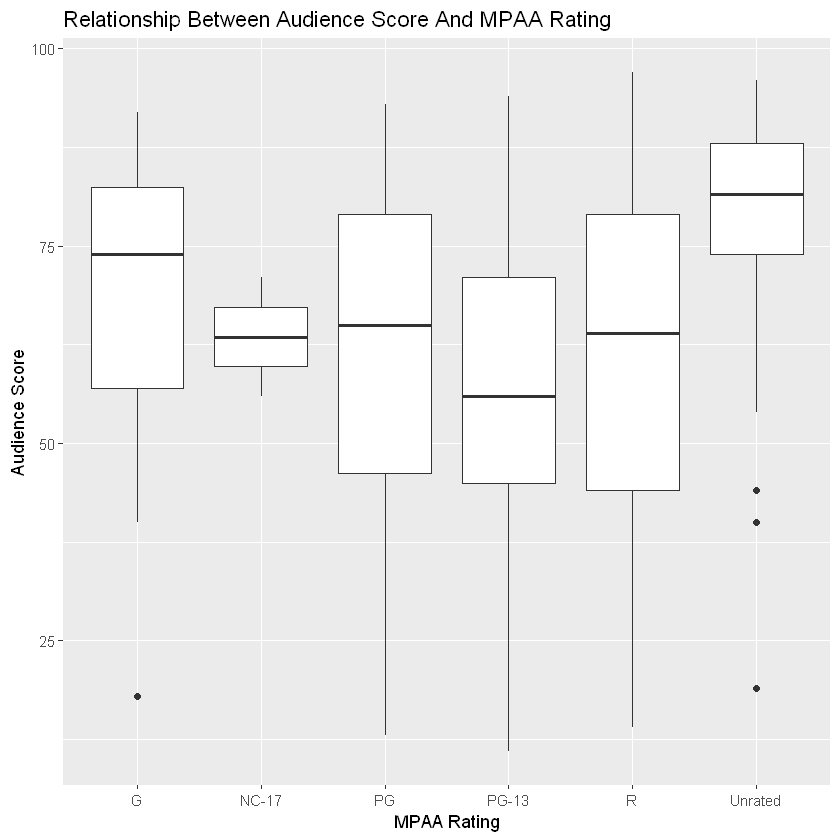

In [132]:
ggplot(data = movies3, aes(x = mpaa_rating, y = audience_score)) +
  geom_boxplot() +
  labs(x = "MPAA Rating", y = "Audience Score") +
  ggtitle("Relationship Between Audience Score And MPAA Rating") 

The MPAA rating also has a little impact on audience score. We are also going to try oscar won(indicates whether or not the movie/actor/actress/director ever won an Oscar)

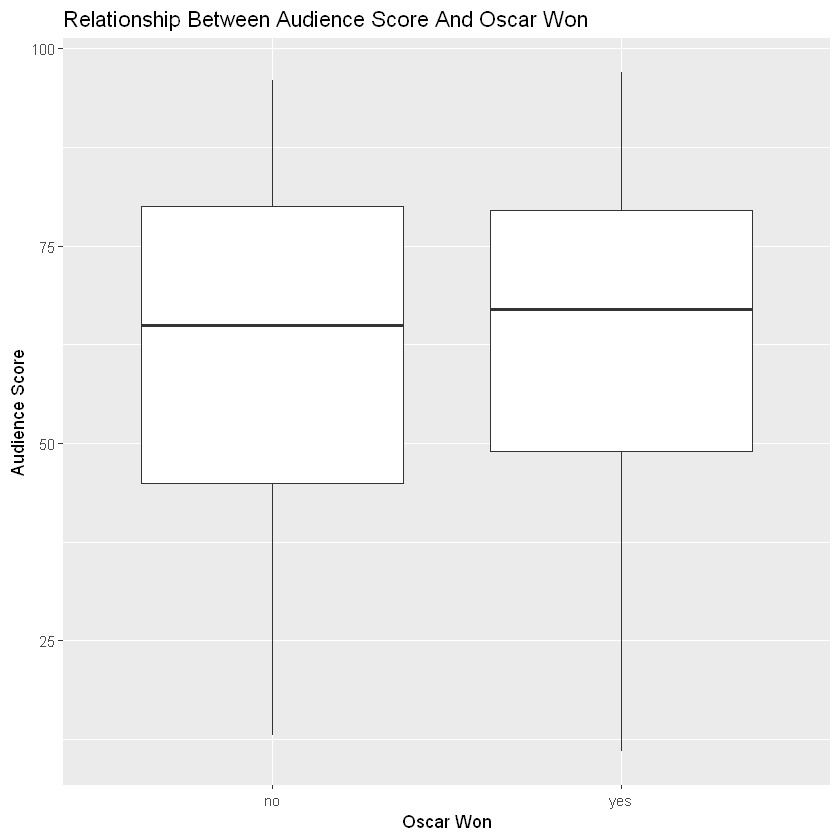

In [133]:
ggplot(data = movies3, aes(x = oscar_won, y = audience_score)) +
  geom_boxplot() +
  labs(x = "Oscar Won", y = "Audience Score") +
  ggtitle("Relationship Between Audience Score And Oscar Won") 

There seems to be little difference between the two distribution, but we are going to keep this variable. The model selection step will decide which variables to use anyway.

In [134]:
#checking correlation matrix
corrmatrix <- na.omit(movies3[c(7,8,10,12)])

cor(corrmatrix)

,imdb_rating,imdb_num_votes,critics_score,audience_score
imdb_rating,1.0000000,0.3311525,0.7650355,0.8648652
imdb_num_votes,0.3311525,1.0000000,0.2092508,0.2898128
critics_score,0.7650355,0.2092508,1.0000000,0.7042762
audience_score,0.8648652,0.2898128,0.7042762,1.0000000


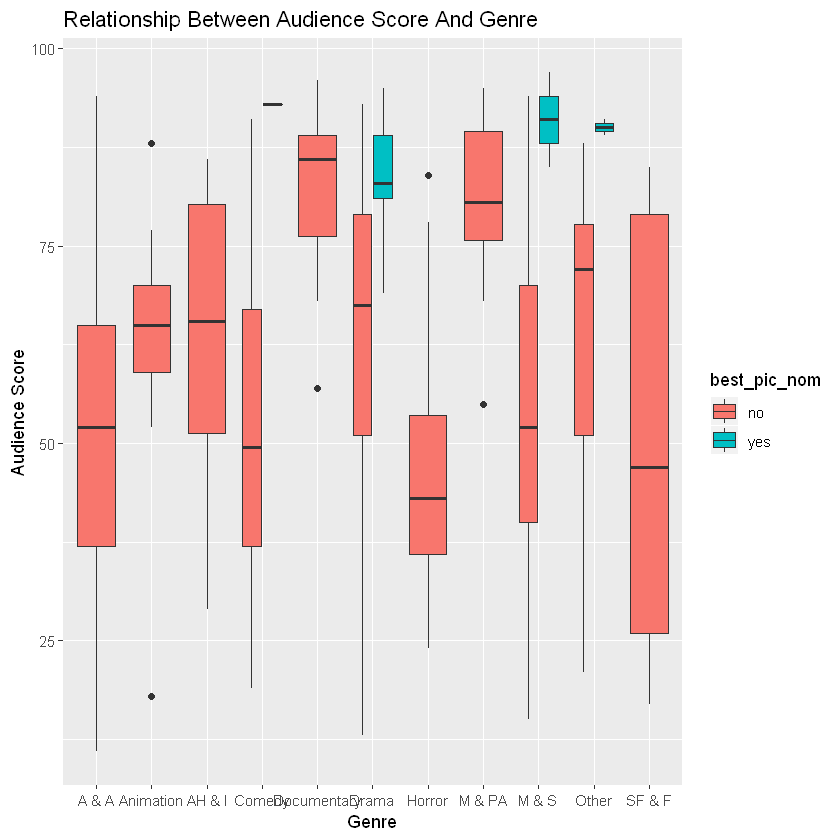

In [135]:
#plotting audiece score vs genre to check if getting nominated for oscar is dependant on genre

ggplot(data = movies3, aes(x = genre, y = audience_score)) +
  geom_boxplot(aes(fill=best_pic_nom)) +
  labs(x = "Genre", y = "Audience Score") +
  ggtitle("Relationship Between Audience Score And Genre")+
# aliasing for long genre names
  scale_x_discrete(labels = c("Action & Adventure" = "A & A", "Art House & International" = "AH & I", "Musical & Performing Arts" = "M & PA", "Mystery & Suspense" = "M & S", "Science Fiction & Fantasy" = "SF & F"))



###  Part 4: Modeling




####  Multiple Linear Model

Let's move on and fit a linear model called fullmodel to predict a movie's audience score by its critic score, genre, MPAA rating, whether it has ever won an Oscar, and whether the has won a best picture Oscar:

In [136]:
model1 <- lm(audience_score ~ critics_score + genre + mpaa_rating + oscar_won + best_pic_nom, data = movies3)

#### <black> Explanation on exclusion of certain variables
We have excluded 3 types of variables:

variables that seem irrelavant to the audience score, such as title(title of movie) and runtime(runtime of movie );

■ variables that are strongly associated with some of the selected explanatory variables, such as title_type(type of movie) which is pretty close to genre, best_pic_win(whether or not the movie has won a best picture Oscar) which is strongly associated with best_pic_nom;

■ variables like imdb_rating are excluded simply because we are working on Rotten Tomatoes and pretend to know nothing about IMDB.

#### <black> Model selection
As for model selection technique, we are going to use backwards elimination with p-value because:

■ backwards elimination is more intuitive: now that we already have the full model, it makes more sense to drop redundant variables one at a time rather than to build the model from scratch by adding one variable at a time, as in forwards selection;

■ using p-value is easier than using adjusted R square. We only have to fit one model at each step;

Let's start by printing the summary of our full model:

In [137]:
summary(model1)


Call:
lm(formula = audience_score ~ critics_score + genre + mpaa_rating + 
    oscar_won + best_pic_nom, data = movies3)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.856  -9.333   0.460   9.348  41.751 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     36.96379    4.04962   9.128  < 2e-16 ***
critics_score                    0.44463    0.02246  19.794  < 2e-16 ***
genreAnimation                   3.94595    5.43533   0.726 0.468119    
genreArt House & International   5.68374    4.20746   1.351 0.177219    
genreComedy                     -1.01932    2.30530  -0.442 0.658522    
genreDocumentary                 9.45690    3.12515   3.026 0.002578 ** 
genreDrama                       1.92984    2.01733   0.957 0.339120    
genreHorror                     -9.49379    3.45943  -2.744 0.006236 ** 
genreMusical & Performing Arts  10.78167    4.47937   2.407 0.016372 *  
genreMystery & Suspense         -4.1774

We can see that 2 of our variables, mpaa_rating and best_dir_win have a significant p-values. The rest of variables either have a insignificant p-value or have at least one level which has an insignificant p-value. We would drop mpaa_rating since it has the most significant p-values, and fit a new model called model2 with the rest of the variables:

In [138]:
model2 <- lm(audience_score ~ critics_score + genre + oscar_won + best_pic_nom, data = movies3)

In [139]:
summary(model2)


Call:
lm(formula = audience_score ~ critics_score + genre + oscar_won + 
    best_pic_nom, data = movies3)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.408  -9.052   0.465   9.050  42.225 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    35.54225    1.95769  18.155  < 2e-16 ***
critics_score                   0.44517    0.02187  20.359  < 2e-16 ***
genreAnimation                  4.80917    4.95352   0.971 0.331987    
genreArt House & International  5.55305    4.10859   1.352 0.176992    
genreComedy                    -1.14161    2.28202  -0.500 0.617062    
genreDocumentary                8.83801    2.77508   3.185 0.001519 ** 
genreDrama                      1.92373    1.96206   0.980 0.327228    
genreHorror                    -9.23240    3.38083  -2.731 0.006493 ** 
genreMusical & Performing Arts 10.69320    4.43973   2.409 0.016300 *  
genreMystery & Suspense        -3.92157    2.53481  -1.547 0.12

We'll drop oscar_won as well since it has a high p_value

In [140]:
model3 <- lm(audience_score ~ critics_score + genre + best_pic_nom, data = movies3)
summary(model3)


Call:
lm(formula = audience_score ~ critics_score + genre + best_pic_nom, 
    data = movies3)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.912  -9.413   0.263   9.303  42.404 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    35.37484    1.94874  18.153  < 2e-16 ***
critics_score                   0.44435    0.02184  20.342  < 2e-16 ***
genreAnimation                  4.75334    4.95247   0.960  0.33752    
genreArt House & International  5.67764    4.10574   1.383  0.16719    
genreComedy                    -1.16710    2.28154  -0.512  0.60915    
genreDocumentary                9.00721    2.76845   3.254  0.00120 ** 
genreDrama                      1.76581    1.95409   0.904  0.36652    
genreHorror                    -9.08085    3.37626  -2.690  0.00734 ** 
genreMusical & Performing Arts 10.72496    4.43899   2.416  0.01597 *  
genreMystery & Suspense        -4.17514    2.51908  -1.657  0.09793 .  
gen

In [141]:
options(warn=-1)

This time all of our explanatory variables do not have a significant p-value, which means that we have reached a parsimonious model.

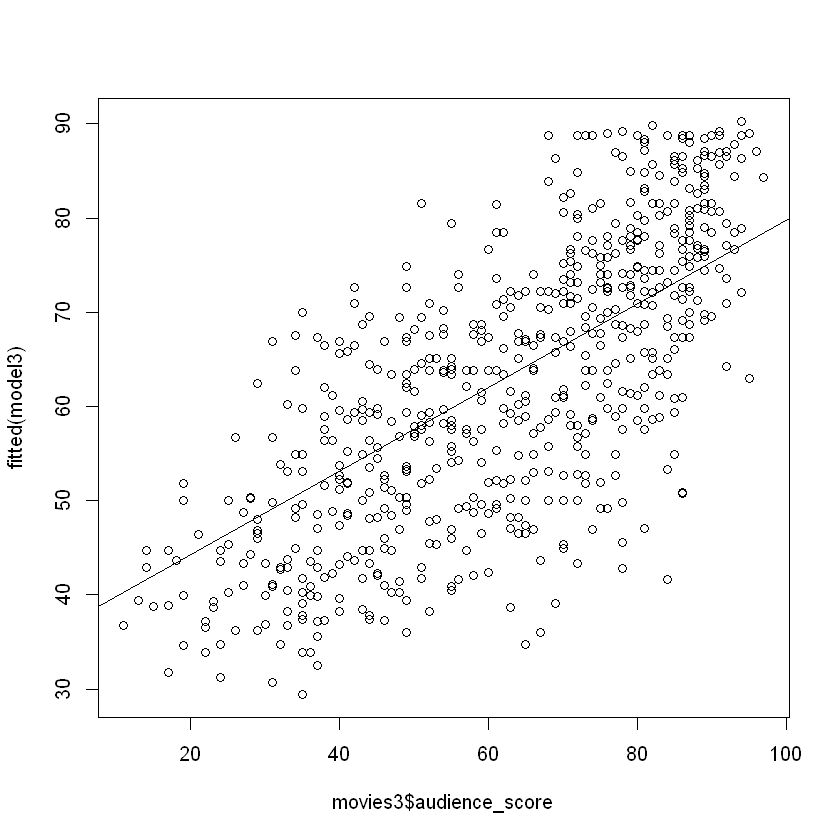

In [142]:
plot(movies3$audience_score, fitted(model3))
abline(lm(audience_score ~ critics_score + genre + best_pic_nom, data = movies3))

####  Model diagnostics
    
Before making predictions, we would like to check if our model satisfies all the conditions for a MLR model.

<b> Linearity:</b> The only numerical explanatory variable we have is critic_score, and we are going to create a scatterplot of the model residuals versus critics scores:

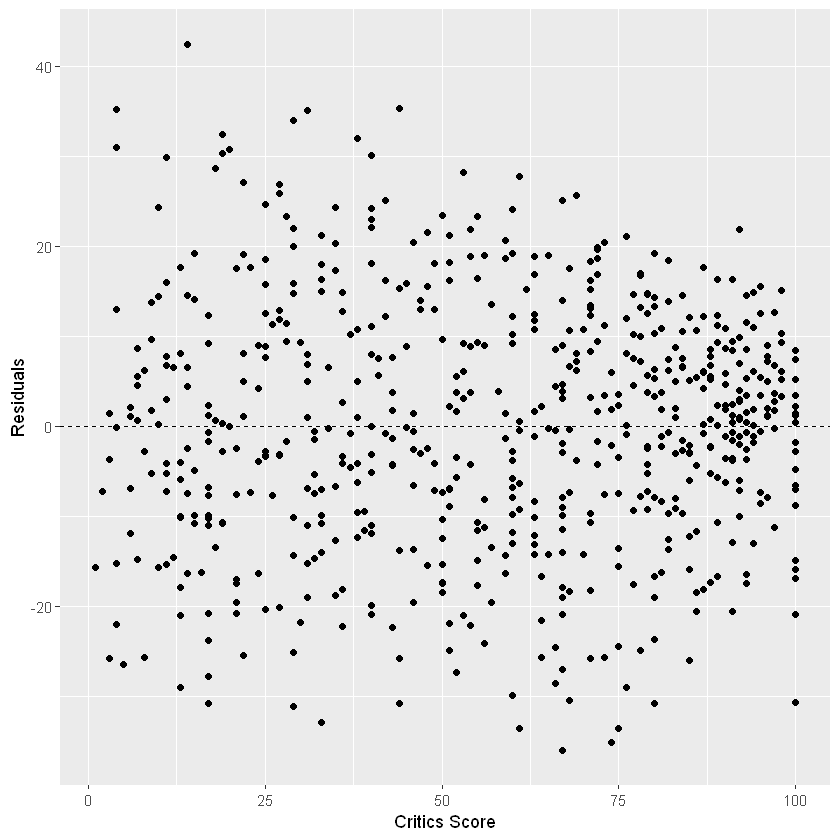

In [143]:
critic_residual <- data.frame(residuals = model3$residuals, critics_score = movies3$critics_score)

ggplot(data = critic_residual, aes(x = critics_score, y = residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Critics Score", y = "Residuals")

We can see that the residuals are distributed randomly scattered around 0, which means that the conditions is met.

####  Variance Inflation Factor
    
To detect multicollinearity in a model we consider the variance inflation factor (VIF) of a variable

In [144]:
1/(1-summary(model3)$r.squared)

[1] 2.152058

So the VIF of achievement test score for this model is around 1.02. This is great news since we only consider multicollinearity to be an issue when VIF>10.

Nearly normal residuals: Let's create a histogram for our model residuals:

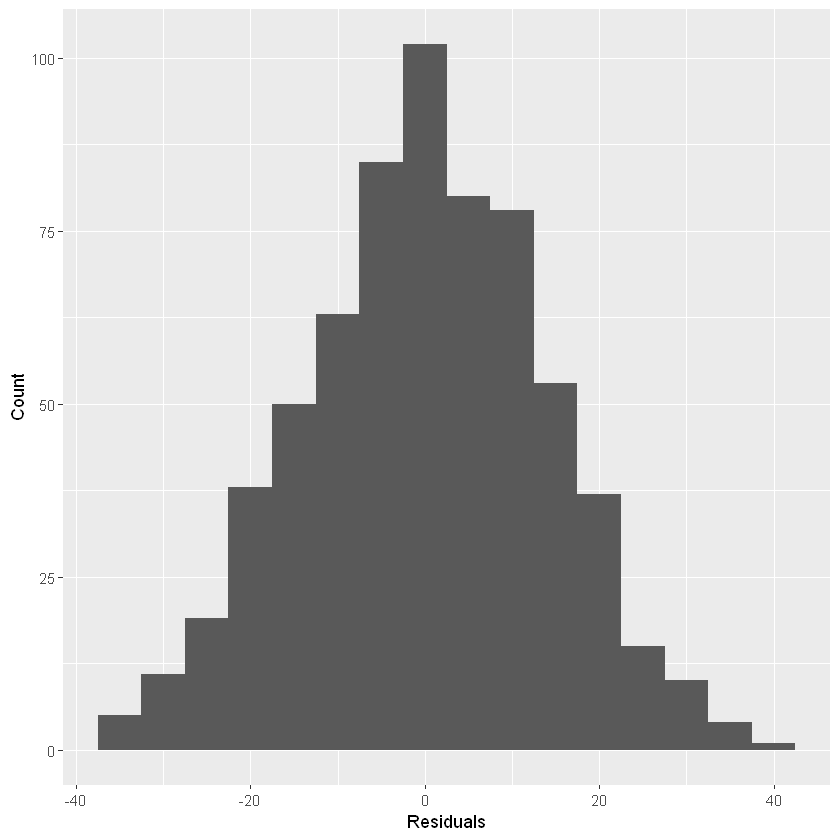

In [145]:
ggplot(data = model3, aes(x = .resid)) +
  geom_histogram(binwidth = 5) +
  labs(x = "Residuals", y = "Count")

The model residuals seems normally distributed around 0, which means that this condition is satisfied as well.

<b> Constant variability of residuals: </b> To check this condition, let's create a scatterplot of model residuals versus fitted values:

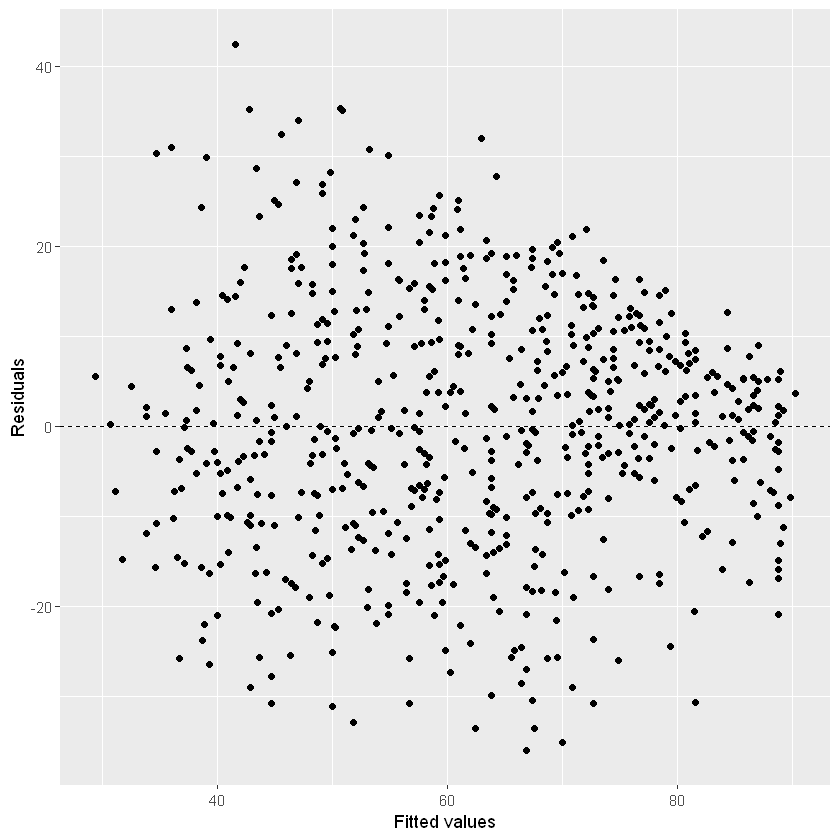

In [146]:
ggplot(data = model3, aes(x = .fitted, y = .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(x = "Fitted values", y = "Residuals")

We can see that the variability of residuals seems to decrease when fitted value is large. This is not surprising, given that the maximum score is 100, a very high score such as 99 could hardly have upward variations because it would hit the ceiling. We are going to ignore the problem here since it seems not a big deal.

<b> Independence of residuals: </b> We assume that this condition is met since independence of observations is satisfied.

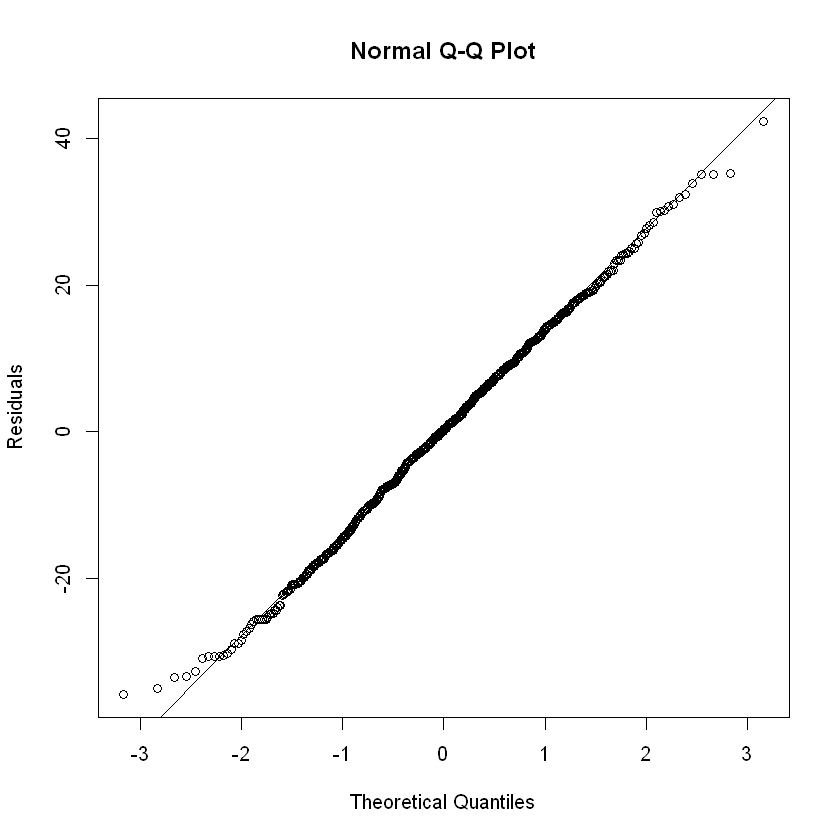

In [147]:
# Plot the quartiles for the residuals and adds a best fit line. 
movies_resid <- residuals(model3) 
qqnorm(movies_resid, ylab = "Residuals") 
qqline(movies_resid)

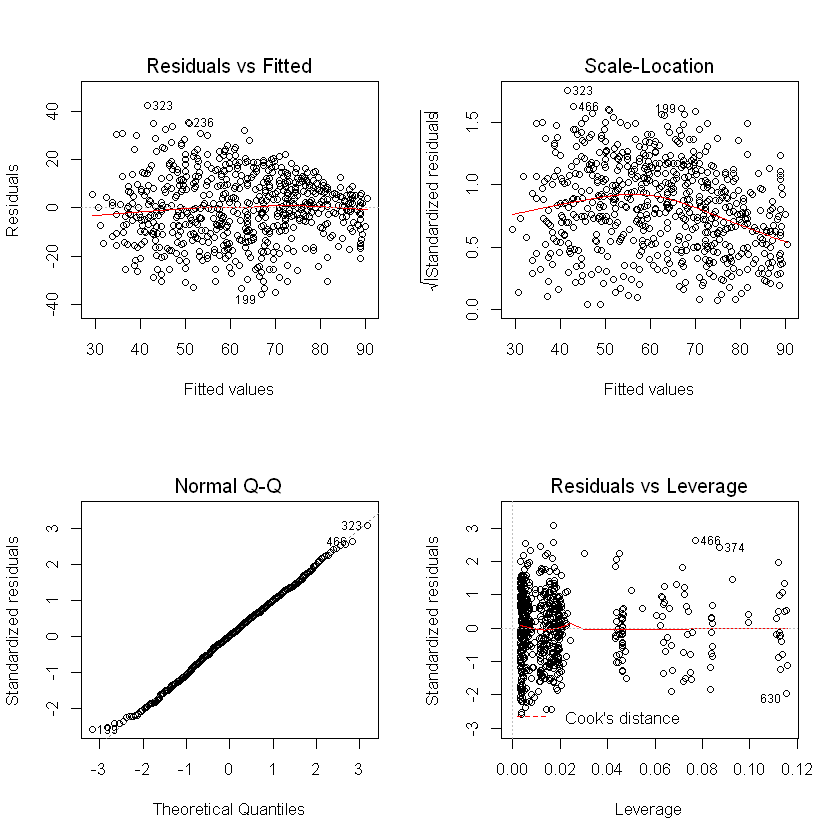

In [148]:
# diagnostic plots
layout(matrix(c(1,2,3,4),2,2)) # optional 4 graphs/page
plot(model3)

####  Interpretation of model coefficients

The model as a whole:

■ <b> f-statistic: </b> the p-value associated to the f-statistic is less than 2.2e-16, meaning the model as a whole is significant, and at least one of the slopes does not equal 0;

■ <b> R2 :</b> our model has an  R2  of 0.5353, meaning that 53.5% of the variability in data is explained by the model;

For each coefficient of our variables:

■ <b> intercept:</b></b> we have an intercept of 35.37484, which means a movie with critics score of 0 is expected to have an audience score of 35.37484;

■ <b> critics score:</b> slope for critics score is 0.44435, which means for every unit of critis score increased, we would expect the audience score to increase by 0.44435 units;

■ <b> genre:</b> the non-reference level is Action & Adventure. If the movie has a different genre, it would be expected to have a corresponding increase/decrease on audience score, e.g., all else held equal, a horror movie is expected to 9.08085 less units on audience score;

■ <b> best picture nomination:</b> according to our model, if a movie was nominated for a best picture Oscar, it would be expected to have 10.03913 more units on audience score;



###  Part 5: Prediction




For the prediction task, we would choose the 2018 movie Searching. Related data is collected from its Rotten Tomatoes Page. First, we create the data frame for the movie:

In [149]:
searching <- data.frame(critics_score = 92, genre = "Mystery & Suspense", best_pic_nom = "no")

predict(model3, searching, interval = "prediction", level = 0.95)

fit,lwr,upr
72.07993,44.47729,99.68258


Our point estimate for Searching's audience score is 72.07993, which is not very precise, given that the true audience score is 88.

Our model also predicts the 95% prediction interval for Searching's audience score to be (44.4772, 99.68258), which means that with 95% confidence, a movie with critics score of 92, the genre of "Mystery & Suspense" and no best picture Oscar nomination is expected to have an audience score between 44.5 and 99.7.

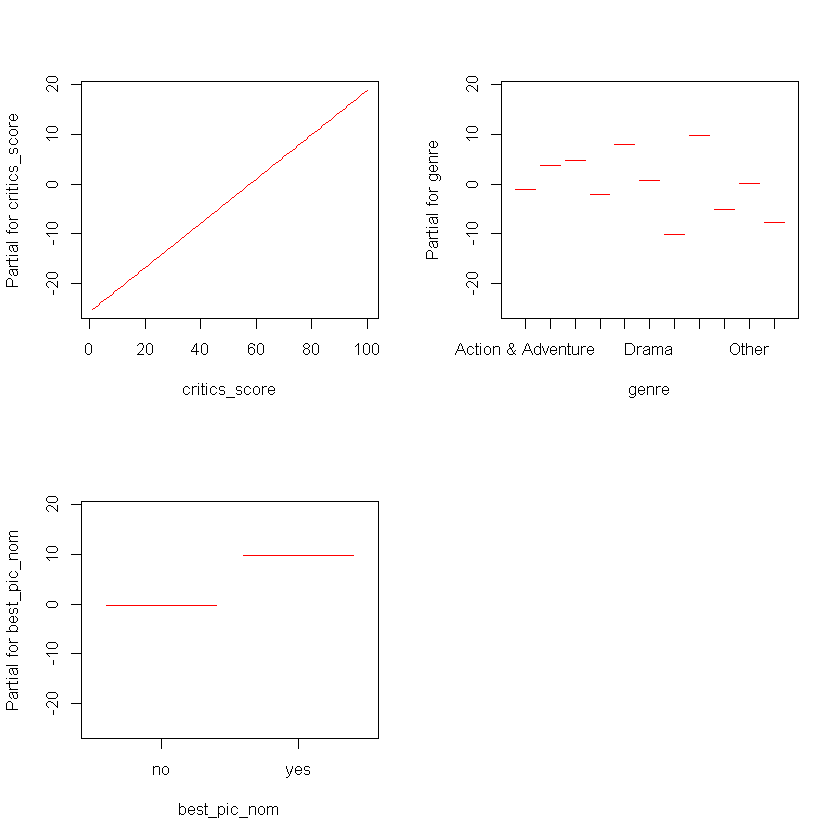

In [150]:
par(mfrow=c(2,2))
termplot(model3)
par(mfrow=c(1,1))



###  Part 6: Conclusion




So far we've proved a strong linear relationship between critics score and audience score, and built a linear regression to predict a movie's audience score by its critics score, genre, and best picture nomination.

However, our model has a relatively low  R2 , which suggests it is still far from perfect. I can think of 2 things to do in the future:

■ if more features could be added to the dataset, we would like to improve the model by including more explanatory variables;

■ a better approach would be to try an alternative regression model where our slope estimation could be different for every different level taken for a categorical explanatory variable(we haven't leaned this in course);